In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import readsav
import glob
from pathlib import Path


matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})

In [3]:
def v_fit(drifts, vmeans):
    ## Calibration parameters: y_measured = p0*x_true + p1 => true = (measured - p1)*1/p0
    p = np.polyfit(drifts, vmeans, 1)
    vxfits = p[0] * drifts + p[1]
    a_v = 1 / p[0]
    vxfits2 = (vmeans - p[1]) * a_v
    # Calculate residuals
    residuals = np.abs(vxfits - vmeans)
    residuals2 = np.abs(vxfits2 - drifts)
    return vxfits, residuals, vxfits2, residuals2, p

In [4]:
def read_vi(file, data_str):
    idl_dict = readsav(file)
    vi = idl_dict[data_str]
    return vi

dv = 0.04
drifts = np.arange(-0.2, 0.21, dv)
fwhm = 7
pad = 10
trange = [0,27]

In [5]:
datadir = os.path.expanduser('~/Data/sanity_check/flct_results/')
lctfiles0 = list(Path(os.path.join(datadir, 'Stein-simulation-series')).rglob('flct-km-Stein-simul-*.save'))
lctfiles1 = list(Path(os.path.join(datadir, 'Stein-simulation-2skip')).rglob('flct-km-Stein-simul-*.save'))
lctfiles2 = list(Path(os.path.join(datadir, 'Stein-simulation-3skip')).rglob('flct-km-Stein-simul-*.save'))
lctfiles0.sort()
lctfiles1.sort()
lctfiles2.sort()
lctfiles = [lctfiles0, lctfiles1, lctfiles2]
# for filelist in lctfiles:
#     for f in filelist:
#         print(f)

In [6]:
vxs = [[read_vi(file, 'vx') for file in lctfiles_skip] for lctfiles_skip in lctfiles]
vys = [[read_vi(file, 'vy') for file in lctfiles_skip] for lctfiles_skip in lctfiles]

vxs2 = [[vx[trange[0]:trange[1], pad:-pad, pad:-pad].mean()/(i+1) for vx in vxs_skip] for i, vxs_skip in enumerate(vxs)]

In [7]:
vxfits = []
residuals = []
vxfits2 = []
residuals2 = []
px_means = []
for vxmeans in vxs2:
    fit, res, fit2, res2, p = v_fit(drifts, vxmeans)
    vxfits.append(fit)
    residuals.append(res)
    vxfits2.append(fit2)
    residuals2.append(res2)
    px_means.append(p)

## Plot FLCT velocity against drift velocity

<IPython.core.display.Javascript object>


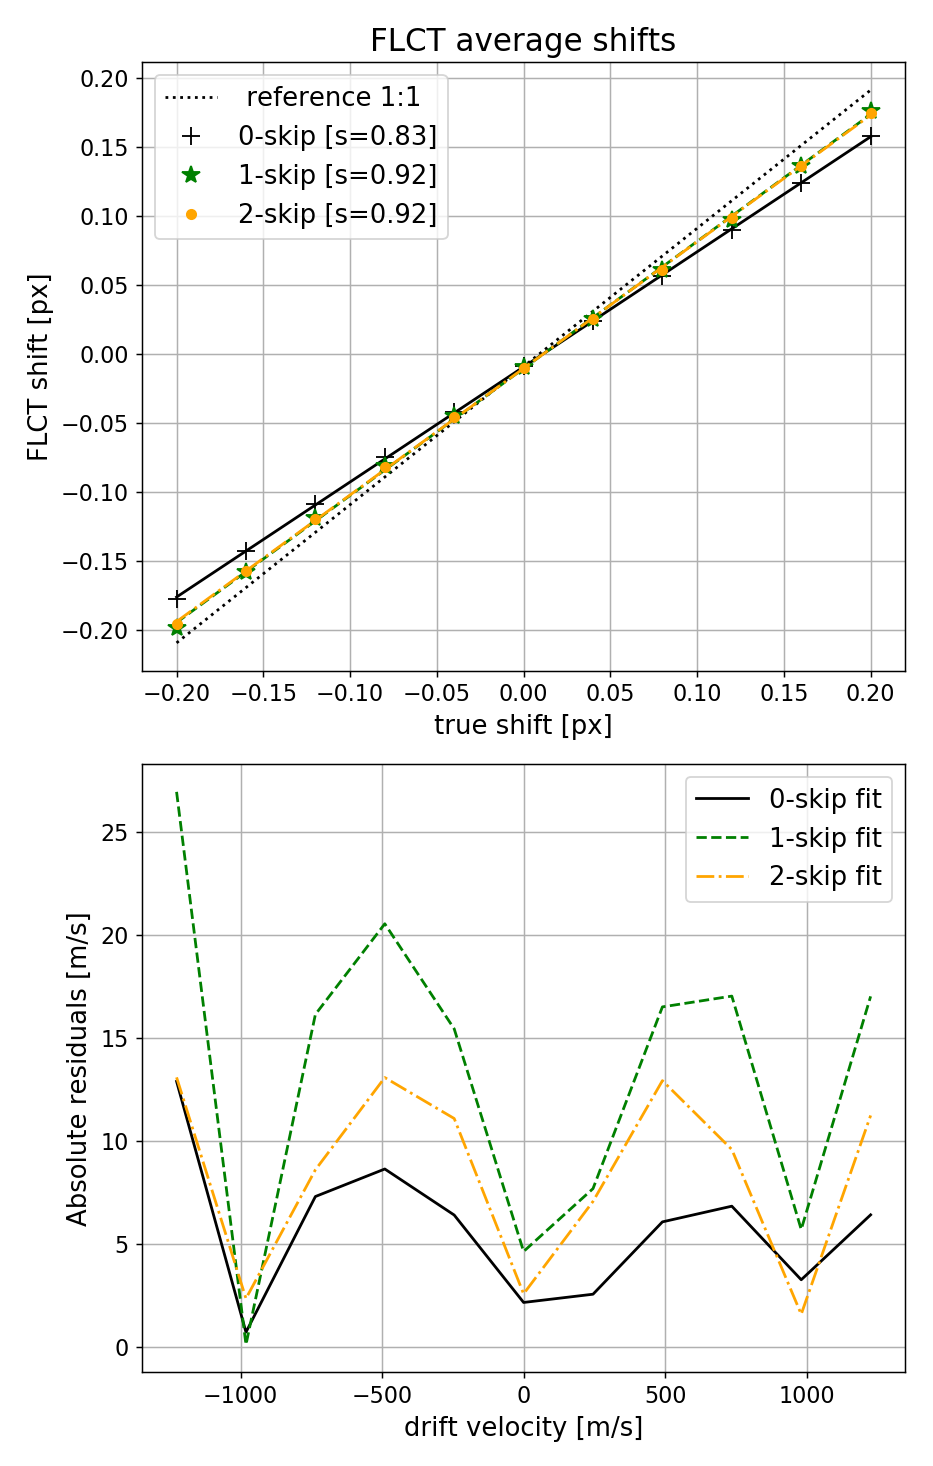

In [8]:
u = 368000 / 60
%matplotlib notebook
fs = 14
colors = ['black', 'green', 'orange']
markers = ['+', '*', '.']
ls = ['-', '--', '-.']
fig, ax = plt.subplots(2,1, figsize = (7,11))
ax[0].plot(drifts, drifts + vxs2[0][5], 'k:', label=' reference 1:1')
for i in range(3):
    ax[0].plot(drifts, vxs2[i], marker=markers[i], ms=10, ls='none', color=colors[i], 
               label = '{:d}-skip [s={:1.2f}]'.format(i, px_means[i][0]))
    ax[0].plot(drifts, vxfits[i], ls=ls[i], color=colors[i])#, label = '{:d}-skip fit'.format(i))
ax[0].grid(True, axis='both')
ax[0].set_xlabel('true shift [px]')
ax[0].set_ylabel('FLCT shift [px]')
# plt.xlim([0, 2])
# plt.ylim([0, 2])
ax[0].legend()
ax[0].set_title('FLCT average shifts')

for i in range(3):
    ax[1].plot(drifts*u, residuals2[i]*u, ls=ls[i], color=colors[i], label = '{:d}-skip fit'.format(i))

ax[1].set_xlabel('drift velocity [m/s]')
ax[1].set_ylabel('Absolute residuals [m/s]')
ax[1].grid(True, axis='both')
ax[1].legend(fontsize=fs)
plt.tight_layout()
plt.savefig(os.path.join(datadir, 'flct_sanity_check_on_drifts.png'), dpi=300)


### Load Stein MHD simulation velocity and get correlation with FLCT

In [9]:
import fitsio
from scipy.signal import convolve2d
from scipy.ndimage.filters import gaussian_filter 

def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy


def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm])/(fwhm**2)
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
        
    return vxs2, vys2


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson

# Index at zero drift
vidx = 5

In [22]:
data_dir_stein = os.path.expanduser('~/Data/Ben/SteinSDO/')
svx_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vy*.fits')))

vx_stein, vy_stein = load_vel_mean((svx_files, svy_files), trange)

# Select a subfield excluding edge effects
# Use same padding size as in Tremblay et al. 2018 used pad = 10
step = 10
fov = np.s_[pad:-pad:step, pad:-pad:step]
# Get true mean velocity (unit already in m/s)
vx_stein_mean = vx_stein[fov].mean()
print(vx_stein_mean, 'm/s')

# smooth the Stein velocities 
vx_stein_sm, vy_stein_sm = smooth_vel(vx_stein, vy_stein, fwhm, kernel='gaussian') 



-141.99866 m/s


#### Get FLCT at zero drift and calculate Pearson correlation with velocity from Stein simulation

In [23]:
vx_flct_list = [vxs_skip[vidx][trange[0]:trange[1],...].mean(axis=0)/(i+1) for i, vxs_skip in enumerate(vxs)]
vy_flct_list = [vys_skip[vidx][trange[0]:trange[1],...].mean(axis=0)/(i+1) for i, vys_skip in enumerate(vys)]

mask = None #vx_flct_list[0][fov]<0.2


x = np.linspace(-2000, 2000, 100)
px = []
rx = []
npts = vx_stein_sm[fov].size
for i in range(3):
    p, r, _, _, _ = np.polyfit(vx_stein_sm[fov][mask].ravel(), vx_flct_list[i][fov][mask].ravel()*u, 1, full=True)
    px.append(p)
    rx.append(np.sqrt(r[0]/npts))

In [24]:
c_pearsons = [calc_c_pearson(vx_stein_sm, vx_flct, vy_stein_sm, vy_flct, fov=fov) for (vx_flct, vy_flct) 
              in zip(vx_flct_list, vy_flct_list)]

print(c_pearsons)

[0.91509575, 0.8975096, 0.804662]


<IPython.core.display.Javascript object>


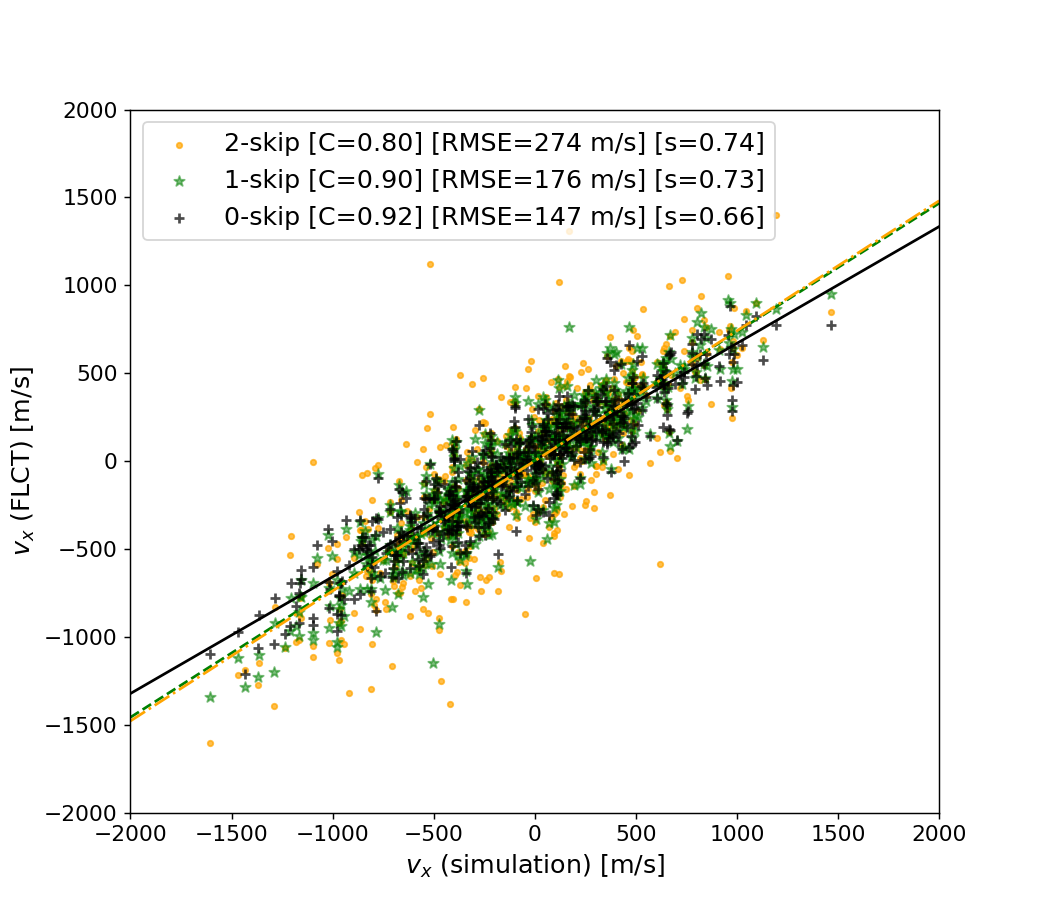

In [25]:
%matplotlib notebook

plt.figure(figsize=(8,7))

plt.scatter(vx_stein_sm[fov].ravel(), vx_flct_list[2][fov].ravel()*u, marker='.', color=colors[2], alpha=0.7, label = '2-skip [C={:1.2f}] [RMSE={:1.0f} m/s] [s={:1.2f}]'.format(c_pearsons[2], rx[2], px[2][0]))
plt.scatter(vx_stein_sm[fov].ravel(), vx_flct_list[1][fov].ravel()*u, marker='*', color=colors[1], alpha=0.5, label = '1-skip [C={:1.2f}] [RMSE={:1.0f} m/s] [s={:1.2f}]'.format(c_pearsons[1], rx[1], px[1][0]))
plt.scatter(vx_stein_sm[fov].ravel(), vx_flct_list[0][fov].ravel()*u, marker='+', color=colors[0], alpha=0.7, label = '0-skip [C={:1.2f}] [RMSE={:1.0f} m/s] [s={:1.2f}]'.format(c_pearsons[0], rx[0], px[0][0]))

for i in range(3):
    plt.plot(x, np.poly1d(px[i])(x), ls[i], color=colors[i])

plt.axis([-2000, 2000, -2000, 2000])
plt.xlabel(r'$v_x$ (simulation) [m/s]')
plt.ylabel(r'$v_x$ (FLCT) [m/s]')
plt.legend()
plt.savefig(os.path.join(datadir, 'flct_simulation_correlations.png'), dpi=300)

In [16]:
# Load Balltrack velocities
datadir2 = os.path.join(os.environ['DATA'], 'Ben/SteinSDO')
bfiles = sorted(glob.glob(os.path.join(datadir2, 'balltrack/vxy*.npz')))
bvxys = [np.load(bfile) for bfile in bfiles]
bvx = bvxys[0]['vx']
bvy = bvxys[0]['vy']
bcorr = calc_c_pearson(vx_stein_sm, bvx, vy_stein_sm, bvy, fov=fov)

bp, br, _, _, _ = np.polyfit(vx_stein_sm[fov].ravel(), bvx[fov].ravel()*u, 1, full=True)
br = np.sqrt(br[0]/npts)

<IPython.core.display.Javascript object>


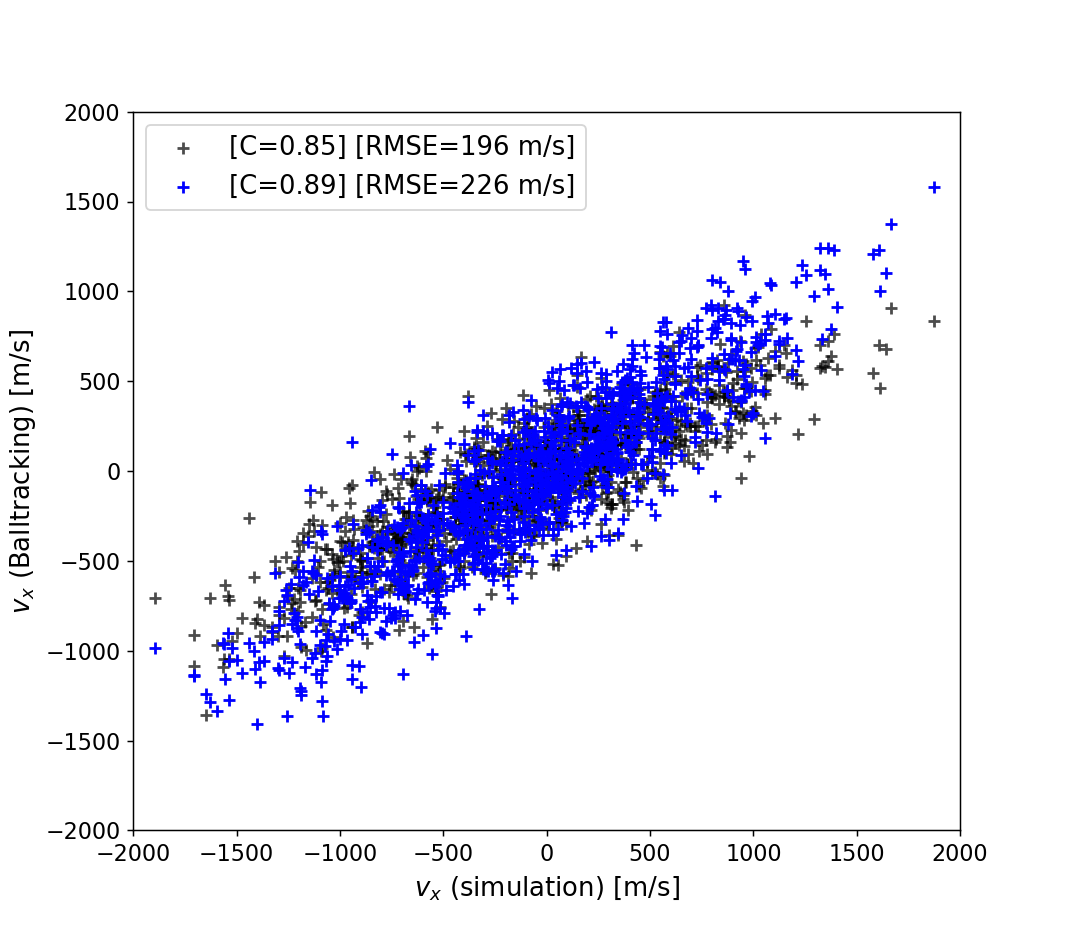

In [17]:
%matplotlib notebook

plt.figure(figsize=(8,7))
plt.scatter(vx_stein_sm[fov].ravel(), vx_flct_list[0][fov].ravel()*u, marker='+', color='black', alpha=0.7, label = '[C={:1.2f}] [RMSE={:1.0f} m/s]'.format(c_pearsons[0], rx[0]))
plt.scatter(vx_stein_sm[fov].ravel(), bvx[fov].ravel()*u, marker='+', color='blue', alpha=1.0, label = '[C={:1.2f}] [RMSE={:1.0f} m/s]'.format(bcorr, br))
plt.axis([-2000, 2000, -2000, 2000])
plt.xlabel(r'$v_x$ (simulation) [m/s]')
plt.ylabel(r'$v_x$ (Balltracking) [m/s]')
plt.legend()
#plt.savefig(os.path.join(datadir, 'balltrack_flct_simulation_correlations.png'), dpi=300)
